In [1]:
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Data Loading and Preprocessing
Taken from kaggle kernel: https://www.kaggle.com/laowingkin/netflix-movie-recommendation

### Loading all data files 

In [7]:
# Skip date
df1 = pd.read_csv('/home/ubuntu/netflix_cf/data/combined_data_1.txt', header = None, 
                  names = ['cust_Id', 'rating','date'], usecols = [0,1,2])

df1['rating'] = df1['rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 3)
-Dataset examples-
          cust_Id  rating        date
0              1:     NaN         NaN
5000000   2560324     4.0  2005-12-06
10000000  2271935     2.0  2005-04-11
15000000  1921803     2.0  2005-01-31
20000000  1933327     3.0  2004-11-10


In [9]:
# df2 = pd.read_csv('/home/ubuntu/netflix_cf/data/combined_data_2.txt', header = None, 
#                   names = ['cust_Id', 'rating', 'date'], usecols = [0,1,2])
# df3 = pd.read_csv('/home/ubuntu/netflix_cf/data/combined_data_3.txt', header = None, 
#                   names = ['cust_Id', 'rating','date'], usecols = [0,1,2])
# df4 = pd.read_csv('/home/ubuntu/netflix_cf/data/combined_data_4.txt', header = None,
#                   names = ['cust_Id', 'rating','date'], usecols = [0,1,2])


# df2['rating'] = df2['rating'].astype(float)
# df3['rating'] = df3['rating'].astype(float)
# df4['rating'] = df4['rating'].astype(float)

# print('Dataset 2 shape: {}'.format(df2.shape))
# print('Dataset 3 shape: {}'.format(df3.shape))
# print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (26982302, 3)
Dataset 3 shape: (22605786, 3)
Dataset 4 shape: (26851926, 3)


In [14]:
# load less data for speed

df = df1
# df = df1.append(df2)
# df = df.append(df3)
# df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 3)
-Dataset examples-
          cust_Id  rating        date
0              1:     NaN         NaN
5000000   2560324     4.0  2005-12-06
10000000  2271935     2.0  2005-04-11
15000000  1921803     2.0  2005-01-31
20000000  1933327     3.0  2004-11-10


### Adding Movie Id column to this

In [16]:
df_nan = pd.DataFrame(pd.isnull(df.rating))
df_nan = df_nan[df_nan['rating'] == True]
df_nan = df_nan.reset_index()

In [17]:
df_nan.shape

(4499, 2)

In [ ]:
df_nan[::1000,:]

In [22]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [32]:
df.shape

(24053764, 4)

#### Adding movie id to original dataframe

In [23]:
# remove those Movie ID rows
df = df[pd.notnull(df['rating'])]

df['movie_Id'] = movie_np.astype(int)
df['cust_Id'] = df['cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


-Dataset examples-
          cust_Id  rating        date  movie_Id
1         1488844     3.0  2005-09-06         1
5000996    501954     2.0  2004-08-26       996
10001962   404654     5.0  2005-08-29      1962
15002876   886608     2.0  2005-09-19      2876
20003825  1193835     2.0  2003-08-13      3825


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
# saving this dataframe

df.to_pickle('/home/ubuntu/netflix_cf/data/intermediate_df.pkl')

In [4]:
df = pd.read_pickle('/home/ubuntu/netflix_cf/data/intermediate_df.pkl')

### Adding date time related columns

In [5]:
df['year']= df.date.dt.year
df['dow']= df.date.dt.dayofweek
df['month']= df.date.dt.month

In [6]:
df.sort_values(by='date',ascending=True, inplace=True)

In [7]:
df.reset_index(inplace=True, drop=True)

In [8]:
df[:2]

,cust_Id,rating,date,movie_Id,year,dow,month
0,510180,5.0,1999-11-11,1798,1999,3,11
1,510180,3.0,1999-11-11,2866,1999,3,11


### Encoding data
We enconde the data to have contiguous ids for users and movies.

In [57]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [58]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["cust_Id", "movie_Id", "year", 'dow', 'month']:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [59]:
df_e = encode_data(df)

In [60]:
df_e[:3]

,cust_Id,rating,date,movie_Id,year,dow,month
0,0,5.0,1999-11-11,0,0,0,0
1,0,3.0,1999-11-11,1,0,0,0
2,0,4.0,1999-11-11,2,0,0,0


In [61]:
df.shape, df_e.shape

((24053764, 7), (24053764, 7))

In [62]:
del df

### Train Val Split

Sorting by date to split 20% validation

In [63]:
# split train and validation before encoding
trn_len = df_e.shape[0]- int(0.2*df_e.shape[0])
val_len = int(0.2*df_e.shape[0])

train = df_e[:trn_len].copy()
val = df_e[trn_len:].copy()

In [64]:
train.shape[0]+ val.shape[0] == df_e.shape[0]

True

In [65]:
# saving pickles

train.to_pickle('/home/ubuntu/netflix_cf/data/df_train.pkl')
val.to_pickle('/home/ubuntu/netflix_cf/data/df_val.pkl')

In [9]:
df_train = pd.read_pickle('/home/ubuntu/netflix_cf/data/df_train.pkl')
df_val = pd.read_pickle('/home/ubuntu/netflix_cf/data/df_val.pkl')

In [67]:
df_train[:3]

,cust_Id,rating,date,movie_Id,year,dow,month
0,0,5.0,1999-11-11,0,0,0,0
1,0,3.0,1999-11-11,1,0,0,0
2,0,4.0,1999-11-11,2,0,0,0


### Baseline Model: Matrix Factorization

It's always good to first try these neural net layers on a small sample dataset to see how it looks like before running on the whole dataset

In [6]:
df_mini = df_train.copy()[:10]

In [7]:
df_mini

,cust_Id,rating,date,movie_Id
0,0,5.0,1999-11-11,0
1,0,3.0,1999-11-11,1
2,0,4.0,1999-11-11,2
3,0,2.0,1999-11-11,3
4,0,5.0,1999-11-11,4
5,0,3.0,1999-12-06,5
6,0,3.0,1999-12-06,6
7,0,3.0,1999-12-06,7
8,1,3.0,1999-12-08,8
9,1,3.0,1999-12-08,9


In [7]:
num_users, num_items, emb_size = 2, 10, 10


user_emb = nn.Embedding(num_users, emb_size)
item_emb = nn.Embedding(num_items, emb_size)

In [8]:
user_emb

Embedding(2, 10)

In [19]:
users = Variable(torch.LongTensor(df_mini.cust_Id.values))
items = Variable(torch.LongTensor(df_mini.movie_Id.values))

In [20]:
items

Variable containing:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
[torch.LongTensor of size 10]

In [23]:
# index in embedding layer
U = user_emb(users)
V = item_emb(items)

In [28]:
U.shape, V.shape

(torch.Size([10, 10]), torch.Size([10, 10]))

In [31]:
(U*V).sum(1)

Variable containing:
-1.0729
-1.0216
 1.7603
-3.0100
 0.7900
-0.7482
 1.4096
 2.6721
 0.4361
-2.0313
[torch.FloatTensor of size 10]

#### Dataset class and dataloader

In [33]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
    
    'Characterizes a dataset for PyTorch'
    def __init__(self, movies, users, ratings):
        'Initialization'
        self.movies = movies
        self.users = users
        self.ratings = ratings
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ratings)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        U = self.movies[index]
        V = self.users[index]
        y = self.ratings[index]

        return [U, V, y]

In [64]:
users = torch.LongTensor(df_train.cust_Id.values)
movies = torch.LongTensor(df_train.movie_Id.values)
ratings = torch.FloatTensor(df_train.rating.values)

train_dataset = Dataset(users, movies, ratings)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100000, shuffle=True)

In [65]:
train_dataset[:2]

[
  0
  0
 [torch.LongTensor of size 2], 
  0
  1
 [torch.LongTensor of size 2], 
  5
  3
 [torch.FloatTensor of size 2]]

In [66]:
tl = iter(train_loader)

In [67]:
next(tl)

[
  1.1441e+05
  1.7940e+05
  2.4209e+05
      ⋮     
  1.1411e+05
  1.9630e+05
  1.6677e+05
 [torch.LongTensor of size 100000], 
  1146
  1426
  2645
   ⋮  
  1610
    27
  1570
 [torch.LongTensor of size 100000], 
  3
  3
  3
 ⋮ 
  5
  3
  3
 [torch.DoubleTensor of size 100000]]

In [135]:
# validation dataloader

users_val = torch.LongTensor(df_val.cust_Id.values)
movies_val = torch.LongTensor(df_val.movie_Id.values)
ratings_val = torch.FloatTensor(df_val.rating.values)

val_dataset = Dataset(users_val, movies_val, ratings_val)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100000, shuffle=True)

In [136]:
val_dataset

#### Training MF model with bias

In [82]:
class MF_bias(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF_bias, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        # init 
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        return (U*V).sum(1) +  b_u  + b_v

In [70]:
# iteration per epoch
20000000/100000

200.0

In [109]:
for i, data in enumerate(train_loader):
    U,V,y = data
    break
    

In [110]:
U,V,y

(
  4.1952e+04
  1.2634e+05
  1.0288e+05
      ⋮     
  2.5643e+04
  1.3268e+05
  2.6544e+05
 [torch.LongTensor of size 100000], 
   703
  2535
  2884
   ⋮  
  3016
   744
  3144
 [torch.LongTensor of size 100000], 
  2
  4
  2
 ⋮ 
  4
  4
  5
 [torch.DoubleTensor of size 100000])

In [16]:
# instantiating model class
num_users = len(df_train.cust_Id.unique())
num_items = len(df_train.movie_Id.unique())
print(num_users, num_items)

389223 4403


In [ ]:
model = MF_bias(num_users, num_items, emb_size=100).cuda()  # if you have a GPU .cuda()

In [85]:
# 389223*100, 4403*100 and 1*() bias learnable params

[p for p in model.parameters()]

[Parameter containing:
 1.00000e-02 *
  1.3964  0.2576  0.8163  ...   0.9777  1.1301  4.6421
  2.2505  1.5438  4.5505  ...   1.1837  1.6772  4.9862
  2.5746  1.3042  0.8057  ...   2.3677  3.7980  2.8203
           ...             ⋱             ...          
  2.5007  3.4935  0.8847  ...   4.0331  3.1606  4.1015
  4.0530  1.7925  2.6780  ...   4.3488  3.7237  0.2395
  1.9705  0.3177  1.9255  ...   0.4876  4.2783  4.8671
 [torch.FloatTensor of size 389223x100], Parameter containing:
  6.3819e-03
  6.9740e-03
 -7.4664e-03
      ⋮      
  1.6735e-03
 -7.1889e-03
 -2.5451e-03
 [torch.FloatTensor of size 389223x1], Parameter containing:
  1.7135e-02  8.7493e-03  1.0590e-02  ...   3.1343e-03  2.2114e-02  2.2622e-02
  3.2340e-02  3.3855e-02  4.0062e-03  ...   2.4309e-02  8.8655e-03  4.0964e-02
  1.5294e-02  2.6389e-02  4.6789e-02  ...   6.6698e-03  3.5113e-02  5.1873e-03
                 ...                   ⋱                   ...                
  1.3312e-02  4.7135e-02  9.1409e-03  ...   9

In [125]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    model.train() # into training mode
    for i in range(epochs):
        running_loss = 0.0
        
        for j, data in enumerate(train_loader):
            users, items, ratings = data
            users = Variable(users)
            items = Variable(items)
            ratings = Variable(ratings).float()
            
            users = users.cuda() # put on gpu
            items = items.cuda()
            ratings = ratings.cuda()            
            if unsqueeze:
                ratings = ratings.unsqueeze(1)
            y_hat = model(users, items)
            loss = F.mse_loss(y_hat, ratings)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]
        print("training loss for epoch ",i+1, ": ", running_loss/j+1) # used to be loss.data[0]
    test_loss(model, unsqueeze)

In [126]:
# lets see what unsqueeze does

ratings = torch.FloatTensor(df_train.rating.values)
print(ratings.shape)
ratings = ratings.unsqueeze(1)  #.cuda()
ratings.shape

torch.Size([19243012])


torch.Size([19243012, 1])

In [137]:
len(val_loader), len(train_loader)

(27, 193)

In [141]:
# defining test loss which has been used in train_epochs

def test_loss(model, unsqueeze=False):
    model.eval() # go to evaluation mode
    
    running_loss = 0.
    for j, data in enumerate(val_loader):
        users, items, ratings = data
        users, items, ratings = Variable(users), Variable(items), Variable(ratings).float()
        
        users = users.cuda() # put on gpu
        items = items.cuda()
        ratings = ratings.cuda()       
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss_now = F.mse_loss(y_hat, ratings)
        running_loss+= loss_now.data[0]
    print("validation loss", ": ", running_loss/len(val_loader)) # j means this many iterations till end

Running training loop

In [142]:
train_epocs(model, epochs=10, lr=0.01)

training loss for epoch  1 :  1.8164567404116192
training loss for epoch  2 :  1.7305999736612043
training loss for epoch  3 :  1.681645206796626
training loss for epoch  4 :  1.6428651694829264
training loss for epoch  5 :  1.609310308160881
training loss for epoch  6 :  1.5779485749080777
training loss for epoch  7 :  1.5482694699118533
training loss for epoch  8 :  1.519811940845102
training loss for epoch  9 :  1.4926153641814988
training loss for epoch  10 :  1.4670419896331925
validation loss :  3.554822330121641


Validation loss is high, but training loss is low. How to debug this? Let's see distribution of training and validation data

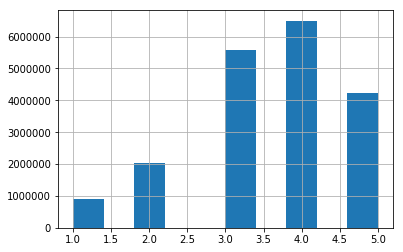

In [155]:
df_train.rating.hist()

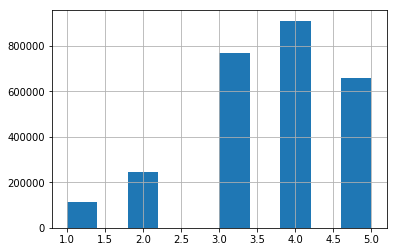

In [156]:
df_val.rating.hist()

Test and train distributions are same. Difference in training and validation losses might not be due to covariance shift then. Let's try `weidht_decay` to prevent overfitting

In [158]:
train_epocs(model, epochs=5, lr=0.001, wd=1e-5)

training loss for epoch  1 :  1.3959827586077154
training loss for epoch  2 :  1.3933158125728369
training loss for epoch  3 :  1.4095620855999489
training loss for epoch  4 :  1.430343547835946
training loss for epoch  5 :  1.452937744402637
validation loss :  1.7792416590231437


So, `weight decay` helps

In [160]:
train_epocs(model, epochs=5, lr=0.0001, wd=1e-6) # lower learning rate # lower regularization

training loss for epoch  1 :  1.4596793348900974
training loss for epoch  2 :  1.4576306299616892
training loss for epoch  3 :  1.4560284797723095
training loss for epoch  4 :  1.454666225084414
training loss for epoch  5 :  1.453537404537201
validation loss :  1.709446355148598


We can train even further to decrease validation and train loss, but I would carry on with neural net version as it might perform better than MF version. Also, it takes time to train each epoch even on GPUs

## Neural Net Model

#### without date related columns

In [161]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.
    
class CollabFNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=10):
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.1) # changed from 0. actually can do only with dropout 1
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = torch.cat([U, V], dim=1)
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.drop2(x)
        x = self.lin2(x)
        return x

In [167]:
model_nn = CollabFNet(num_users, num_items, emb_size=100).cuda()

In [170]:
train_epocs(model_nn, epochs=5, lr=0.01, unsqueeze=True)

training loss for epoch  1 :  1.9723842836295566
training loss for epoch  2 :  1.896787578550478
training loss for epoch  3 :  1.8759232955053449
training loss for epoch  4 :  1.8693881261472902
training loss for epoch  5 :  1.8592914401864014
validation loss :  0.9192858669492934


Not overfitting yet. Let's try 3 more epochs with same lr

In [171]:
train_epocs(model_nn, epochs=3, lr=0.01, unsqueeze=True)

training loss for epoch  1 :  1.8429234139621258
training loss for epoch  2 :  1.8270095620925226
training loss for epoch  3 :  1.8185425773262978
validation loss :  0.9005276008888528


In [172]:
train_epocs(model_nn, epochs=3, lr=0.01, unsqueeze=True)

training loss for epoch  1 :  1.8143312806884446
training loss for epoch  2 :  1.8084728177636862
training loss for epoch  3 :  1.804810949911674
validation loss :  0.9094064809657909


In [182]:
y_hat = model(Variable(torch.LongTensor(df_val.cust_Id.values)).cuda(),
              Variable(torch.LongTensor(df_val.movie_Id.values)).cuda())

In [199]:
y_hat.data.cpu().numpy().min(), y_hat.data.cpu().numpy().max()

(-66.29216, 77.088524)

#### Ratings that are being predicted are way off than the range of 0 to 5. Adding last sigmoid layer to predict ratings between 0 and 5 only

In [68]:
df_train[:3]

,cust_Id,rating,date,movie_Id,year,dow,month
0,0,5.0,1999-11-11,0,0,0,0
1,0,3.0,1999-11-11,1,0,0,0
2,0,4.0,1999-11-11,2,0,0,0


In [69]:
df_val[:3]

,cust_Id,rating,date,movie_Id,year,dow,month
19243012,388544,3.0,2005-08-01,2604,6,1,9
19243013,258382,3.0,2005-08-01,1930,6,1,9
19243014,141157,4.0,2005-08-01,1930,6,1,9


In [10]:
# yr_mean = df_train.year.mean()
# dow_mean = df_train.dow.mean()
# mnth_mean = df_train.month.mean()

# yr_std = df_train.year.std()
# dow_std = df_train.dow.std()
# mnth_std = df_train.month.std()

In [11]:
# df_train['year'] = (df_train.year - yr_mean)/ yr_std
# df_train['dow'] = (df_train.dow - dow_mean)/ dow_std
# df_train['month'] = (df_train.month - mnth_mean)/ mnth_std

In [12]:
# df_val['year'] = (df_val.year - yr_mean)/ yr_std
# df_val['dow'] = (df_val.dow - dow_mean)/ dow_std
# df_val['month'] = (df_val.month - mnth_mean)/ mnth_std

In [10]:
import torch
from torch.utils import data

class Dataset2(data.Dataset):
    
    'Characterizes a dataset for PyTorch'
    def __init__(self, df):
        'Initialization'
        self.movies = torch.LongTensor(df.movie_Id.values)
        self.users = torch.LongTensor(df.cust_Id.values)
        self.ratings = torch.FloatTensor(df.rating.values)
        self.year = torch.LongTensor(df.year.values)
        self.month = torch.LongTensor(df.month.values)
        self.dow = torch.LongTensor(df.dow.values)        
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ratings)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        Mov = self.movies[index]
        Usr = self.users[index]
        Yr = self.year[index]
        Mon = self.month[index]
        Dow = self.dow[index]
        
        R = self.ratings[index]

        return [Mov, Usr, Yr, Mon, Dow, R]

In [11]:
train_dataset2 = Dataset2(df_train)
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=50000, shuffle=True)

In [12]:
# validation dataloader

val_dataset2 = Dataset2(df_val)
val_loader2 = torch.utils.data.DataLoader(val_dataset2, batch_size=50000, shuffle=False)

In [13]:
train_dataset2[:2]

[
  0
  1
 [torch.LongTensor of size 2], 
  0
  0
 [torch.LongTensor of size 2], 
  0
  0
 [torch.LongTensor of size 2], 
  0
  0
 [torch.LongTensor of size 2], 
  0
  0
 [torch.LongTensor of size 2], 
  5
  3
 [torch.FloatTensor of size 2]]

Result := ((Input - InputLow) / (InputHigh - InputLow)) * (OutputHigh - OutputLow) + OutputLow

In [23]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.
    
class CollabFNet2(nn.Module):
    def __init__(self, 
                 num_items,
                 num_users, 
                 num_yrs, 
                 num_months,
                 num_dow, 
                 emb_size=100, 
                 emb_size2 = 5, n_hidden=20):
        
        super(CollabFNet2, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.yr_emb = nn.Embedding(num_yrs, emb_size2)
        self.dow_emb = nn.Embedding(num_dow, emb_size2)
        self.month_emb = nn.Embedding(num_months, emb_size2)
        
        self.lin1 = nn.Linear(emb_size*2 + emb_size2*3, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.1)  # changed from 0. actually can do only with dropout 1
        
    def forward(self, Mov, Usr, Yr, Mon, Dow):
    
        Usr = self.user_emb(Usr)
        Mov = self.item_emb(Mov)
        Yr = self.yr_emb(Yr)
        Dow = self.dow_emb(Dow)
        Mon = self.month_emb(Mon)        
        
        x = torch.cat([Mov,Usr, Yr, Mon, Dow],dim=1)
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.drop2(x)
        x = self.lin2(x)
        return F.sigmoid(x)*4 + 1 # to make it b/w 1 to 5

In [15]:
def train_epocs2(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    for i in range(epochs):
        model.train() # into training mode
        running_loss = 0.0
        
        for j, (items, users, yr, month, dow, ratings) in enumerate(train_loader2):
            users = Variable(users).cuda()
            items = Variable(items).cuda()
            ratings = Variable(ratings).float().cuda()
            yr = Variable(yr).cuda()
            month = Variable(month).cuda()
            dow = Variable(dow).cuda()            
            
            if unsqueeze:
                ratings = ratings.unsqueeze(1)
            y_hat = model(items, users, yr, month, dow)
            loss = F.mse_loss(y_hat, ratings)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]
        print("training loss for epoch ",i+1, ": ", running_loss/j+1) # used to be loss.data[0]
        test_loss2(model, unsqueeze)

In [21]:
# defining test loss which has been used in train_epochs

def test_loss2(model, unsqueeze=False):
    model.eval() # go to evaluation mode
    
    running_loss = 0.
    for j, (items, users, yr, month, dow, ratings) in enumerate(val_loader2):
        users = Variable(users).cuda()
        items = Variable(items).cuda()
        ratings = Variable(ratings).float().cuda()
        yr = Variable(yr).cuda()
        month = Variable(month).cuda()
        dow = Variable(dow).cuda()
        
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(items, users, yr, month, dow)
        loss_now = F.mse_loss(y_hat, ratings)
        running_loss+= loss_now.data[0]
    print("validation loss", ": ", running_loss/len(val_loader2)) # j means this many iterations till end

In [18]:
# instantiating model class
num_users = len(df.cust_Id.unique())
num_items = len(df.movie_Id.unique())
num_yrs = len(df.year.unique())
num_dow =  len(df.dow.unique())
num_months = len(df.month.unique()) 

print(num_users, num_items, num_yrs, num_dow, num_months)

470758 4499 7 7 12


In [19]:
model_nn2 = CollabFNet2(num_items,
                 num_users, 
                 num_yrs, 
                 num_months,
                 num_dow, 
                        emb_size=50, emb_size2=5).cuda()

In [20]:
model_nn2

CollabFNet2(
  (user_emb): Embedding(470758, 50)
  (item_emb): Embedding(4499, 50)
  (yr_emb): Embedding(7, 5)
  (dow_emb): Embedding(7, 5)
  (month_emb): Embedding(12, 5)
  (lin1): Linear(in_features=115, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=1, bias=True)
)

In [25]:
train_epocs2(model_nn2, epochs=5, lr=0.01, wd=1e-5,unsqueeze=False)

training loss for epoch  1 :  1.960017153682808
validation loss :  1.0423250905017263
training loss for epoch  2 :  1.884606457160165
validation loss :  1.0395030729549448
training loss for epoch  3 :  1.8819063971750438
validation loss :  1.0340662076301181
training loss for epoch  4 :  1.8879277695280812
validation loss :  1.035488827326863
training loss for epoch  5 :  1.8914600601419806
validation loss :  1.0323809864594764


Validation loss is increasing after some epochs. Lets try to find right learning rate using lr finder

In [32]:
def lrfinder(start, end, model, train_loader2):
    model.train() # into training mode
    lrs = np.linspace(start, end, len(train_loader2))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, start)
    losses = []
    
    for j, (items, users, yr, month, dow, ratings) in enumerate(train_loader2):
        optimizer.param_groups[0]['lr'] =lrs[j]

        users = Variable(users).cuda()
        items = Variable(items).cuda()
        ratings = Variable(ratings).float().cuda()
        yr = Variable(yr).cuda()
        month = Variable(month).cuda()
        dow = Variable(dow).cuda()            
        y_hat = model(items, users, yr, month, dow)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
    plt.plot(lrs, losses)

In [39]:
model_nn_copy = CollabFNet2(num_items,
                 num_users, 
                 num_yrs, 
                 num_months,
                 num_dow, 
                        emb_size=100, emb_size2=5).cuda()

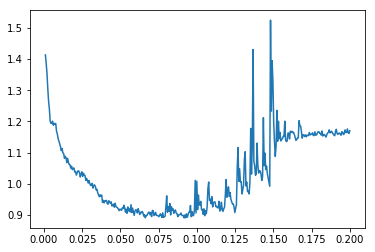

In [40]:
lrfinder(0.001, 0.2, model_nn_copy, train_loader2)

As taught in fastai class, learning rate is starting to increase after 0.05. We can choose 0.025 as good learning rate

In [42]:
train_epocs2(model_nn2, epochs=5, lr=0.025, unsqueeze=True)

training loss for epoch  1 :  1.8758557327091694
validation loss :  1.0232972564156522
training loss for epoch  2 :  1.842201673425734
validation loss :  1.02631219883555
training loss for epoch  3 :  1.832166446528087
validation loss :  1.028887576049136
training loss for epoch  4 :  1.8295468958094716
validation loss :  1.0362612998362668
training loss for epoch  5 :  1.8241126706513264
validation loss :  1.0324596455416728


Ok. Training going down but validation up. let's add some regularization

In [44]:
train_epocs2(model_nn2, epochs=5, lr=0.025,wd=1e-5, unsqueeze=True)

training loss for epoch  1 :  1.8878458694865308
validation loss :  1.0313210849909438
training loss for epoch  2 :  1.8936595402968428
validation loss :  1.028655474333419
training loss for epoch  3 :  1.8919598865322769
validation loss :  1.0280797334061456
training loss for epoch  4 :  1.891211919952184
validation loss :  1.0368618854542369
training loss for epoch  5 :  1.8898136398444572
validation loss :  1.0352515320187992


In [48]:
train_epocs2(model_nn2, epochs=5, lr=0.001,wd=1e-6, unsqueeze=True)

training loss for epoch  1 :  1.8544896307090917
validation loss :  1.0219936254098243
training loss for epoch  2 :  1.8040295336395502
validation loss :  1.0173002376998823
training loss for epoch  3 :  1.770378882996738
validation loss :  1.0184230355872321
training loss for epoch  4 :  1.7562920916825533
validation loss :  1.0282377926344723
training loss for epoch  5 :  1.7439961267324784
validation loss :  1.0265097120373519


In [46]:
# y_hat = model_nn2(Variable(torch.LongTensor(df_val.cust_Id.values)).cuda(),
#               Variable(torch.LongTensor(df_val.movie_Id.values)).cuda())

In [47]:
# y_hat.data.cpu().numpy().min(), y_hat.data.cpu().numpy().max()

### End